In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import torch.backends
from torch.nn import Module, Linear, ReLU
from torch.optim import SGD
from torch.nn import MSELoss

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cudnn.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


# Generate Data

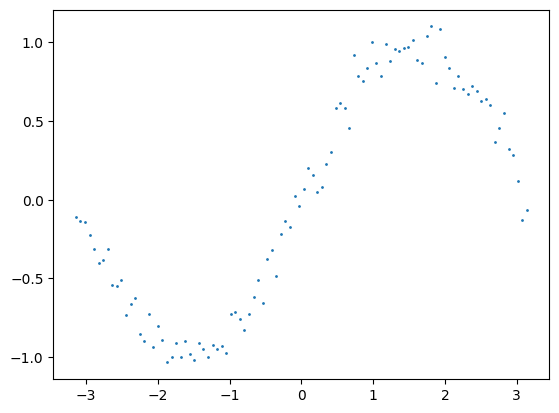

In [10]:
f = np.sin

x = np.linspace(- np.pi, np.pi, 100)
eps = np.random.normal(0, 0.1, 100)

y = f(x) + eps

plt.scatter(x, y, s=1)
plt.show()

x_train = x
y_train = y

In [11]:
# Create Data Set
x = torch.tensor(x, dtype=torch.float32, device=device).reshape(-1, 1)
y = torch.tensor(y, dtype=torch.float32, device=device).reshape(-1, 1)

# Create Data Loader
batch_size = 10
data = torch.utils.data.TensorDataset(x, y)
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Train Model

In [13]:
class NNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NNModel, self).__init__()
        self.linear1 = Linear(input_size, hidden_size)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

def initialize(fhat):
    # Initialize weights to be close to 0
    for param in fhat.parameters():
        param.data.normal_(0, 0.01)

def train(fhat):
    # Training Loop
    optimizer = SGD(fhat.parameters(), lr=0.01)
    regularization = 0.001
    criterion = MSELoss()
    epochs = 1000

    losses = []
    for epoch in range(epochs):
        for x, y in loader:
            optimizer.zero_grad()
            yhat = fhat(x)
            loss = criterion(yhat, y) + regularization * (torch.sum(fhat.linear1.weight ** 2) + torch.sum(fhat.linear2.weight ** 2))
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, Loss: %f" % (epoch, loss.item()))
        losses.append(loss.item())
    
    return np.array(losses)
        

In [17]:
n_params = np.arange(100, 20001, 100)

for n in n_params:
    print(f"Training model with {n} parameters")
    fhat = NNModel(1, n, 1).to(device)
    initialize(fhat)
    loss = train(fhat)

    # Save the model
    torch.save(fhat.state_dict(), f"models/model_{n}.pt")

    # Save the loss
    np.save(f"models/loss_{n}.npy", loss)

    print()

Training model with 10100 parameters
Epoch: 0, Loss: 0.368434
Epoch: 100, Loss: 0.082587
Epoch: 200, Loss: 0.015407
Epoch: 300, Loss: 0.014125
Epoch: 400, Loss: 0.042315
Epoch: 500, Loss: 0.014256
Epoch: 600, Loss: 0.013079
Epoch: 700, Loss: 0.013125
Epoch: 800, Loss: 0.027240
Epoch: 900, Loss: 0.011255

Training model with 10200 parameters
Epoch: 0, Loss: 0.295427
Epoch: 100, Loss: 0.136015
Epoch: 200, Loss: 0.036722
Epoch: 300, Loss: 0.022598
Epoch: 400, Loss: 0.017425
Epoch: 500, Loss: 0.026004
Epoch: 600, Loss: 0.017278
Epoch: 700, Loss: 0.016050
Epoch: 800, Loss: 0.012148
Epoch: 900, Loss: 0.019947

Training model with 10300 parameters
Epoch: 0, Loss: 0.350729
Epoch: 100, Loss: 0.085278
Epoch: 200, Loss: 0.051211
Epoch: 300, Loss: 0.024963
Epoch: 400, Loss: 0.012565
Epoch: 500, Loss: 0.026501
Epoch: 600, Loss: 0.035712
Epoch: 700, Loss: 0.015629
Epoch: 800, Loss: 0.020002
Epoch: 900, Loss: 0.013790

Training model with 10400 parameters
Epoch: 0, Loss: 0.282300
Epoch: 100, Loss: 0.